<a href="https://colab.research.google.com/github/quillaur/data_learning/blob/main/data_science/machine_learning/reinforcement_learning/dqn/frozen_lake_dqn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DQN

* Implementation : 
  * https://towardsdatascience.com/deep-q-learning-tutorial-mindqn-2a4c855abffc
  * https://github.com/mswang12/minDQN/blob/main/minDQN.py
* Explanations: https://towardsdatascience.com/reinforcement-learning-explained-visually-part-5-deep-q-networks-step-by-step-5a5317197f4b
* Good implementation: https://alexandervandekleut.github.io/deep-q-learning/

https://tensorforce.readthedocs.io/en/latest/basics/getting-started.html => installation not working sadly...


https://alexandervandekleut.github.io/deep-q-learning/

In [ ]:
!pip install gymnasium -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 KB 12.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import tensorflow as tf
import gymnasium as gym
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import trange, tqdm
from collections import deque, defaultdict
import random
import pandas as pd
import os
import time

from gymnasium.wrappers import TransformObservation

In [ ]:
def setup_frozenlake_env(n: int=32):
  envs = gym.vector.make("FrozenLake-v1", asynchronous=True, num_envs=n, is_slippery=False)
  # https://stackoverflow.com/a/49790223
  # https://numpy.org/doc/stable/reference/generated/numpy.eye.html
  envs = TransformObservation(envs, lambda obs: np.eye(16)[obs])
  # envs = TransformReward(envs)
  return envs

In [ ]:
envs = setup_frozenlake_env(4)

In [ ]:
episode_rewards = 0
states, info = envs.reset()

In [ ]:
next_states, rewards, dones, truncs, info = envs.step(np.array([0,1,2,3]))

In [ ]:
for i in range(envs.num_envs):
    if dones[i]:
      rewards[i] = 10 if rewards[i] else -10
    
    if (states[i] == next_states[i]).all():
      rewards[i] = -1

episode_rewards += rewards

In [ ]:
for o, no, r in zip(states, next_states, rewards):
  print(o, no, r)

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] -1.0
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 0.0
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 0.0
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] -1.0


In [ ]:
states = next_states

In [ ]:
episode_rewards

array([-1.,  0.,  0., -1.])

In [ ]:
envs.observation_space = states

In [ ]:
(envs.observation_space.shape[1],)

(16,)

In [ ]:
class Agent:
    def __init__(self, state_shape:int=0, num_actions:int=0, num_envs:int=0, 
                 alpha:float=0.001, gamma:float=0.95, epsilon_i:float=1.0, 
                 epsilon_f:float=0.01, n_epsilon:float=0.1, 
                 hidden_sizes:list=[24,24], model_path:str=""):
        """
        Initialize an Agent instance.

        Parameters
        ----------
        state_shape : int
            shape of the state space
        num_actions : int
            number of actions
        num_envs : int
            number of environments
        alpha : float
            learning rate
        gamma : float
            discount factor
        epsilon_i : float
            initial epsilon value for exploration
        epsilon_f : float
            final epsilon value for exploration
        n_epsilon : float
            number of steps to decay epsilon
        hidden_sizes : list
            number of neurons in the hidden layers
        model_path : str
            path of the model to load
        """
        self.epsilon_i = epsilon_i
        self.epsilon_f = epsilon_f
        self.n_epsilon = n_epsilon
        self.epsilon = epsilon_i
        self.discount_factor = gamma
        self.learning_rate = alpha

        self.num_actions = num_actions
        self.state_shape = state_shape
        self.num_envs = num_envs

        if model_path:
          self.Q = self.load_model(model_path)
        else:
          self.Q = self.create_model(hidden_sizes)
        
        # target network
        self.Q_ = self.create_model(hidden_sizes)
        self.optimizer = tf.keras.optimizers.Adam(alpha)

    def create_model(self, hidden_sizes:list)->tf.keras.Model:
        """
        Create a neural network model.

        Parameters
        ----------
        hidden_sizes : list
            number of neurons in the hidden layers

        Returns
        -------
        tf.keras.Model
            the created model
        """
        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Input(shape=self.state_shape))
        for size in hidden_sizes:
            model.add(tf.keras.layers.Dense(size, activation='relu', use_bias='false', kernel_initializer='he_uniform', dtype='float64'))
        model.add(tf.keras.layers.Dense(self.num_actions, activation="linear", use_bias='false', kernel_initializer='zeros', dtype='float64'))

        return model
    
    def load_model(self, model_path):
      return tf.keras.models.load_model(model_path)
    
    def synchronize(self):
        self.Q_.set_weights(self.Q.get_weights())

    def explore_or_act(self, s_t):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.num_actions, size=self.num_envs)

        preds = self.Q.predict(s_t, verbose=0)
        # print(preds.shape)
        return np.argmax(preds, axis=1)
    
    def act(self, states):
      preds = self.Q.predict(states, verbose=0)
      return np.argmax(preds, axis=1)
    
    def reset_epsilon(self):
      self.epsilon = self.epsilon_i
    
    def decay_epsilon(self, n):
        self.epsilon = max(
            self.epsilon_f, 
            self.epsilon_i - (n/self.n_epsilon)*(self.epsilon_i - self.epsilon_f))

    def update(self, s_t, a_t, r_t, s_t_next, truncs, d_t):
      with tf.GradientTape() as tape:
          Q_next = tf.stop_gradient(tf.reduce_max(self.Q_(s_t_next), axis=1)) # note we use Q_ 
          Q_pred = tf.reduce_sum(self.Q(s_t)*tf.one_hot(a_t, self.num_actions, dtype=tf.float64), axis=1)
          loss = tf.reduce_mean(0.5*(r_t + (1-(d_t.any() or truncs.any()))*self.discount_factor*Q_next - Q_pred)**2)
      grads = tape.gradient(loss, self.Q.trainable_variables)
      self.optimizer.apply_gradients(zip(grads, self.Q.trainable_variables))
    
    def save(self, model_name:str):
      self.Q.save(f'dqn_{model_name}')
            

In [ ]:
def load_or_create(envs: gym.vector.VectorEnv, hidden_sizes: list=[24,24], agent_path: str=""):
  if agent_path:
    return Agent((envs.observation_space.shape[1],), # I have to use this trick, because if I apply a transform wrapper to the env, the single_obs ttrib is not changed properly...
                  envs.single_action_space.n, 
                  envs.num_envs,
                  hidden_sizes=hidden_sizes,
                  model_path=agent_path)
  else:
    return Agent((envs.observation_space.shape[1],), 
                  envs.single_action_space.n, 
                  envs.num_envs,
                  hidden_sizes=hidden_sizes)

In [ ]:
class ReplayBuffer:
    """
    A class to store and sample from a replay buffer.
    """
    def __init__(self, size: int = 1000000):
        """
        Initialize the replay buffer with a maximum size.
        :param size: maximum size of the replay buffer, default is 1000000
        """
        self.memory = deque(maxlen=size)
        
    def remember(self, states: np.ndarray, actions: np.ndarray, 
                 rewards: np.ndarray, next_states: np.ndarray, 
                 truncs: np.ndarray, dones: np.ndarray):
        """
        Append a new experience to the replay buffer.
        :param states: states of the environment
        :param actions: actions taken by the agent
        :param rewards: rewards received
        :param next_states: next states of the environment
        :param truncs: flag indicating if the episode was truncated
        :param dones: flag indicating if the episode was done
        """
        self.memory.append((states, actions, rewards, next_states, truncs, dones))
        
    def sample(self, num: int = 32):
        """
        Sample 'num' experiences from the replay buffer.
        :param num: number of experiences to sample, default is 32
        :return: a list of 'num' randomly chosen experiences
        """
        num = min(num, len(self.memory))
        return random.sample(self.memory, num)

In [ ]:
def plot_history(history:pd.DataFrame, name: str):
  history["mean"].plot(xlabel="Epochs", ylabel="Average Rewards Earned (with std)", title="Average Rewards Eearned per Epoch")
  plt.fill_between(history["mean"].index, history["mean"]-history["std"], history["mean"]+history["std"], alpha=0.2)
  plt.savefig(f"{name}_performance.png")

In [ ]:
def test(envs, agent: Agent, agent_path: str="", episodes: int=100):
  if not agent:
    agent = Agent(model_path=agent_path)
  
  history = []
  states, info = envs.reset()
  episode_rewards = 0

  # with tqdm(total=episodes) as pbar:
  while len(history) < episodes:
    actions = agent.act(states)
    next_states, rewards, dones, truncs, infos = envs.step(actions)

    for i in range(envs.num_envs):
      if dones[i]:
        rewards[i] = 100 if rewards[i] else -100
      
      if (states[i] == next_states[i]).all():
        rewards[i] = -1

    episode_rewards += rewards

    # print(states)
    # print(next_states)
    # print(episode_rewards)

    states = next_states

    if np.any(dones) or np.any(truncs):
      for i in range(envs.num_envs):
        if dones[i] or truncs[i]:
          history.append(episode_rewards[i])
          episode_rewards[i] = 0

  return (np.mean(history), np.std(history))

In [ ]:
def train(envs, agent, buffer, n_turns: int):
  state, info = envs.reset()
  agent.reset_epsilon()
  for t in trange(n_turns):
    if t%10 == 0:          
      agent.synchronize()
      
    action = agent.explore_or_act(state)
    state_next, reward, done, trunc, info = envs.step(action)

    for i in range(envs.num_envs):
      if done[i]:
        reward[i] = 100 if reward[i] else -100
      
      if (state[i] == state_next[i]).all():
        reward[i] = -1


    buffer.remember(state, action, reward, state_next, trunc, done)
    state = state_next
    
    agent.decay_epsilon(t/n_turns)

    for batch in buffer.sample(1):
      agent.update(*batch)
  
  return (buffer, agent)

In [ ]:
def run(name: str, envs, agent, buffer, epochs, steps_per_epoch):   
  averages = []
  variations = []

  for e in range(epochs): 
    print(f"######## Epoch {e} ########")
    buffer, agent = train(envs, agent, buffer, steps_per_epoch)
    
    print("Test score:", end=" ")
    mean_rewards, std_rewards = test(envs, agent, episodes=envs.num_envs)
    print(f"{round(mean_rewards,2)} rewards +/- {round(std_rewards,2)}\n")
    
    averages.append(mean_rewards)
    variations.append(std_rewards)

  agent_path = os.path.join("models", name)
  agent.save(agent_path)
  print(f"Agent saved to: {agent_path}")

  return pd.DataFrame(
      {
        "mean": averages,
        "std": variations
      }
  )

In [ ]:
envs = setup_frozenlake_env(4)

In [ ]:
%%time
n_envs = 30
envs = setup_frozenlake_env(n_envs)
# I have to use that trick because the observation space is not redefined 
# uppon using an observation wrapper...
envs.observation_space = envs.reset()[0]

agent = load_or_create(envs, hidden_sizes=[256,256])

buffer = ReplayBuffer()

print("Initial test score:", end=" ")
mean_rewards, std_rewards = test(envs, agent, episodes=envs.num_envs)
print(f"{round(mean_rewards,2)} rewards +/- {round(std_rewards,2)}\n")

history = run("FrozenLake_dqn", envs, agent, buffer, epochs=5, steps_per_epoch=2000)

Initial test score: -100.0 rewards +/- 0.0

######## Epoch 0 ########


  0%|          | 0/2000 [00:00<?, ?it/s]

Test score: 0.0 rewards +/- 0.0

######## Epoch 1 ########


  0%|          | 0/2000 [00:00<?, ?it/s]

Test score: 0.0 rewards +/- 0.0

######## Epoch 2 ########


  0%|          | 0/2000 [00:00<?, ?it/s]

Test score: 100.0 rewards +/- 0.0

######## Epoch 3 ########


  0%|          | 0/2000 [00:00<?, ?it/s]

Test score: 100.0 rewards +/- 0.0

######## Epoch 4 ########


  0%|          | 0/2000 [00:00<?, ?it/s]

Test score: 

100.0 rewards +/- 0.0

Agent saved to: models/FrozenLake_dqn
CPU times: user 10min 13s, sys: 24.2 s, total: 10min 37s
Wall time: 11min 17s


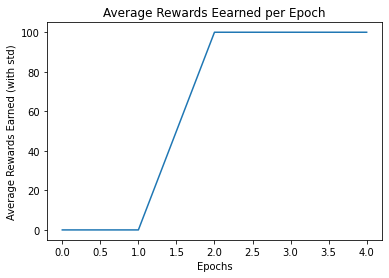

In [ ]:
plot_history(history, "frozenlake_dqn")

In [ ]:
agent.Q.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 256)               4352      
                                                                 
 dense_31 (Dense)            (None, 256)               65792     
                                                                 
 dense_32 (Dense)            (None, 4)                 1028      
                                                                 
Total params: 71,172
Trainable params: 71,172
Non-trainable params: 0
_________________________________________________________________
